# Single-site voltage trace

author: laquitainesteeve@gmail.com  

purpose: plot single-site voltage trace from a site in layer 5 from Horvath depth 2.

Execution time: 1 min

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz) - No GPU required.

Required: RAM: > 40 GB

### Setup

Activate `spikebias` env kernel

In [1]:
# SETUP PACKAGESP
%load_ext autoreload
%autoreload 2
import os
from os.path import join
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface
import spikeinterface as si
import yaml
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import spikeinterface.preprocessing as spre
print("spikeinterface", spikeinterface.__version__)

# move to project path
# proj_path = "/Users/steeve_laquitaine/Desktop/2022_2024_bbp/spikebias/"
proj_path = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(proj_path)

# custom package
from src.nodes.validation import noise

# pipeline parameters
SAVE_FIG_DATA = False
SAVE_FIG = False

# SETUP PARAMETERS
LAYER = "L5"

# setup local path
REC_PATH = "dataset/00_raw/recording_horvath_probe2"
FIG_DATA_PATH = "dataset/02_figure_dataset/fig2e_compo_vivo_horv.npy"

# setup recording parameters (as described in the paper)
DURATION = 900 # seconds
GAIN_TO_UV = 0.195
FREQ_MIN = 300
REF = "global"
OPERATOR = "median"

# FIGURE SETTINGS
FIG_SIZE = (0.9, 0.7)
COLOR_HV = [0.3, 0.3, 0.3]

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 
plt.rcParams["xtick.minor.width"] = 0.5 
plt.rcParams["ytick.major.width"] = 0.5 
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1

# legend
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

spikeinterface 0.100.5


## Clear RAM

In [2]:
# clear RAM
import getpass; password = getpass.getpass("Enter your sudo password: ")
!sync; echo {password} | sudo -S sh -c 'echo 1 > /proc/sys/vm/drop_caches'

[sudo] password for steeve: 

## Load/prep data

In [9]:
%%time 

# load recording
Recording = si.load_extractor(REC_PATH)

# set gain to uV (0.195 described in https://doi.org/10.1038/s41597-021-00970-3)
Recording.set_channel_gains(GAIN_TO_UV)

# get shorter dration
Recording = Recording.frame_slice(0, int(DURATION * Recording.get_sampling_frequency()))

# preprocess
Recording = spre.highpass_filter(Recording, freq_min=FREQ_MIN)
Recording = spre.common_reference(Recording, reference=REF, operator=OPERATOR)

# report
print(Recording)
print("gain:", Recording.get_channel_gains())

CommonReferenceRecording: 128 channels - 20.0kHz - 1 segments - 18,000,000 samples 
                          900.00s (15.00 minutes) - float32 dtype - 8.58 GiB
gain: [0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195]
CPU times: user 3.09 ms, sys: 714 µs, total: 3.81 ms


## Extract voltage trace

In [4]:
%%time 

# get a site in layer 5
LAYER = "L5"
L5_SITE = 79 
SAMPLE_START = 15868440

# get site id
layers = Recording.get_property("layers")
site = np.where(layers == LAYER)[0][L5_SITE]

# extract traces
traces = Recording.get_traces(channel_ids=[str(site)], return_scaled=True)

# extract a one-second period
one_sec_period = np.arange(SAMPLE_START, SAMPLE_START + Recording.get_sampling_frequency(), 1).astype(int)

# extract site trace within period
fig_data = traces[one_sec_period, :]

# save figure data
if SAVE_FIG_DATA:
    np.save(FIG_DATA_PATH, fig_data)

CPU times: user 50 s, sys: 7.21 s, total: 57.2 s
Wall time: 58.7 s


## Plot

CPU times: user 11.8 ms, sys: 1.97 ms, total: 13.7 ms
Wall time: 17.9 ms


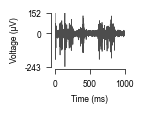

In [8]:
%%time 

yticks = np.array([np.ceil(fig_data.min()), 0, np.ceil(fig_data.max())]).astype(int)

# setup plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot extracted voltage trace
ax.plot(fig_data, color=COLOR_HV)

# aesthetics
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time (ms)")
ax.set_xticks([0, Recording.get_sampling_frequency() / 2, Recording.get_sampling_frequency()], [0, 500, 1000])
ax.set_xlim([0, Recording.get_sampling_frequency()])
ax.set_yticks(yticks, yticks)
ax.set_yticklabels(yticks)
ax.set_ylim([yticks[0], yticks[-1]])
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# save
if SAVE_FIG:
    plt.savefig("figures/0_validation/1_components/fig2e_compo_vivo_horv.svg", dpi=300, transparent=True, bbox_inches="tight")